# Working with time series, frequency series, and unit conversion

In this notebook, we show some of the most useful features of the [timeseries](../series.rst) module. To do so, we will analyze a fake gravitational-wave signal. We will also show the [frequencyseries](../series.rst) module and the [unitconv](../unitconv.rst) modules.

First, let's generate this signal. 

(This notebook is meant to be converted in Sphinx documentation and not used directly.)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from kuibit import timeseries as ts
from kuibit import series
from kuibit import unitconv as uc
from kuibit.gw_utils import luminosity_distance_to_redshift

%matplotlib inline

In [2]:
t = np.linspace(0, 20, 5000)
y = np.sin(t)

# Generate a TimeSeries by providing the times and the values of the series
gw = ts.TimeSeries(t, y)

To access the times and the values, use ``gw.t`` and ``gw.y``. You can also iterate over the series with a for loop yielding the elements `(t, y)` at each iteration of the loop. For example.

In [3]:
for tt, yy in gw:
    print(tt, yy)

0.0 0.0
0.004000800160032006 0.004000789486971321
0.008001600320064013 0.008001514935783532
0.012002400480096018 0.012002112309302542
0.016003200640128026 0.016002517572444287
0.020004000800160033 0.020002666693199687
0.024004800960192037 0.024002495643659576
0.028005601120224044 0.028001940401039562
0.03200640128025605 0.03200093694870479
0.03600720144028806 0.03599942127719461
0.040008001600320066 0.03999732938524717
0.04400880176035207 0.0439945972808238
0.048009601920384073 0.04799116098213332
0.05201040208041608 0.05198695651865616
0.05601120224044809 0.055981919932168285
0.060012002400480095 0.059975987277764924
0.0640128025605121 0.06396909462488413
0.0680136027205441 0.06796117805833003
0.07201440288057612 0.07195217367929596
0.07601520304060812 0.07594201760638712
0.08001600320064013 0.07993064597664322
0.08401680336067213 0.08391799494656059
0.08801760352070415 0.08790400069311417
0.09201840368073615 0.09188859941477902
0.09601920384076815 0.09587172733255157
0.10002000400080

2.988597719543909 0.152398762009658
2.992598519703941 0.1484434857211143
2.996599319863973 0.144485833389645
3.000600120024005 0.14052586836293945
3.004600920184037 0.13656365402570494
3.008601720344069 0.13259925379865206
3.012602520504101 0.12863273113747958
3.016603320664133 0.12466414953185873
3.020604120824165 0.12069357250441701
3.024604920984197 0.11672106360972143
3.028605721144229 0.11274668643326116
3.032606521304261 0.10877050459042982
3.036607321464293 0.1047925817255072
3.040608121624325 0.10081298151064057
3.044608921784357 0.09683176764482546
3.048609721944389 0.09284900385288615
3.052610522104421 0.08886475388445561
3.056611322264453 0.08487908151295515
3.060612122424485 0.08089205053457353
3.064612922584517 0.07690372476724595
3.068613722744549 0.07291416804963251
3.0726145229045807 0.06892344424009673
3.0766153230646127 0.06493161721568182
3.0806161232246447 0.06093875087109071
3.0846169233846767 0.0569449091176617
3.0886177235447088 0.05295015588234582
3.092618523704

5.853170634126825 -0.4168841396867376
5.857171434286857 -0.41324424714061425
5.861172234446889 -0.40959774004980276
5.865173034606921 -0.4059446767816834
5.869173834766953 -0.40228511580857707
5.873174634926985 -0.39861911570680936
5.877175435087017 -0.39494673515577317
5.881176235247049 -0.39126803293698914
5.885177035407081 -0.387583067933165
5.889177835567113 -0.383891899127253
5.893178635727145 -0.38019458560150576
5.897179435887177 -0.37649118653653074
5.901180236047209 -0.3727817612103427
5.905181036207241 -0.3690663689974151
5.9091818363672735 -0.3653450693677297
5.9131826365273055 -0.3616179218858246
5.9171834366873375 -0.35788498620984077
5.9211842368473695 -0.3541463220905674
5.9251850370074015 -0.3504019893704851
5.9291858371674335 -0.34665204798280846
5.9331866373274655 -0.34289655795052637
5.9371874374874976 -0.33913557938544153
5.94118823764753 -0.3353691724872082
5.945189037807562 -0.33159739754236855
5.949189837967594 -0.32782031492338776
5.953190638127626 -0.3240379850

0.7852337992921743
8.525705141028206 0.7827502285201425
8.529705941188238 0.7802541287500618
8.53370674134827 0.777745539935455
8.537707541508302 0.7752245022297491
8.541708341668334 0.7726910559856334
8.545709141828366 0.7701452417544123
8.549709941988398 0.7675871002853576
8.55371074214843 0.7650166725250549
8.557711542308462 0.7624339996167493
8.561712342468494 0.7598391228996862
8.565713142628526 0.7572320839084501
8.569713942788558 0.7546129243722989
8.57371474294859 0.751981686214497
8.577715543108622 0.7493384115516439
8.581716343268655 0.7466831426929997
8.585717143428687 0.7440159221398083
8.589717943588719 0.7413367925846168
8.59371874374875 0.7386457969105926
8.597719543908783 0.7359429781908365
8.601720344068815 0.7332283796876937
8.605721144228847 0.7305020448520607
8.609721944388879 0.7277640173226906
8.61372274454891 0.725014340925494
8.617723544708943 0.7222530596728377
8.621724344868975 0.7194802177628404
8.625725145029007 0.7166958595786649
8.629725945189039 0.7139000

-0.8875850101211606
11.478295659131826 -0.8857349671320977
11.482296459291858 -0.8838707467320664
11.48629725945189 -0.8819923787604883
11.490298059611922 -0.8800998932832358
11.494298859771954 -0.8781933205921516
11.498299659931986 -0.876272691204564
11.502300460092018 -0.8743380358627977
11.50630126025205 -0.8723893855336824
11.510302060412082 -0.870426771408057
11.514302860572114 -0.86845022490027
11.518303660732146 -0.8664597776476771
11.522304460892178 -0.8644554615101344
11.52630526105221 -0.8624373085694889
11.530306061212242 -0.8604053511290646
11.534306861372274 -0.8583596217131455
11.538307661532306 -0.8563001530664552
11.542308461692338 -0.8542269781536328
11.54630926185237 -0.8521401301587047
11.550310062012402 -0.8500396424845542
11.554310862172434 -0.8479255487523865
11.558311662332466 -0.8457978828011903
11.562312462492498 -0.8436566786871966
11.56631326265253 -0.8415019706833333
11.570314062812562 -0.8393337932786767
11.574314862972594 -0.8371521811778996
11.57831566313

0.9474187745576985
14.466893378675735 0.9461309541420007
14.470894178835767 0.9448279895941817
14.474894978995799 0.9435099017699878
14.478895779155831 0.9421767117672347
14.482896579315863 0.9408284409254687
14.486897379475895 0.939465110825626
14.490898179635927 0.9380867432896871
14.494898979795959 0.9366933603803274
14.498899779955991 0.9352849844005638
14.502900580116023 0.9338616378933985
14.506901380276055 0.9324233436414572
14.510902180436087 0.9309701246666251
14.51490298059612 0.9295020042296782
14.518903780756151 0.9280190058299109
14.522904580916183 0.92652115320476
14.526905381076215 0.9250084703294247
14.530906181236247 0.9234809814164827
14.53490698139628 0.9219387109155028
14.538907781556311 0.9203816835126537
14.542908581716343 0.9188099241303086
14.546909381876375 0.9172234579266463
14.550910182036407 0.9156223102952484
14.55491098219644 0.9140065068646936
14.558911782356471 0.9123760734981463
14.562912582516503 0.9107310362929435
14.566913382676535 0.9090714215801768

17.307461492298458 -0.9995881288144673
17.31146229245849 -0.9994653144359965
17.315463092618522 -0.9993265022353363
17.319463892778554 -0.9991716944343674
17.323464692938586 -0.9990008935110024
17.327465493098618 -0.9988141021991461
17.33146629325865 -0.9986113234886512
17.335467093418682 -0.9983925606252709
17.339467893578714 -0.9981578171106069
17.343468693738746 -0.9979070967020531
17.347469493898778 -0.997640403412736
17.35147029405881 -0.9973577415114496
17.355471094218842 -0.9970591155225881
17.359471894378874 -0.9967445302260727
17.363472694538906 -0.9964139906572752
17.367473494698938 -0.996067502106938
17.37147429485897 -0.9957050701210884
17.375475095019002 -0.995326700500951
17.379475895179034 -0.9949323993028536
17.383476695339066 -0.9945221728381315
17.3874774954991 -0.9940960276730255
17.39147829565913 -0.9936539706285774
17.395479095819162 -0.9931960087805204
17.399479895979194 -0.9927221494591661
17.403480696139226 -0.9922324002492873
17.40748149629926 -0.99172676898999

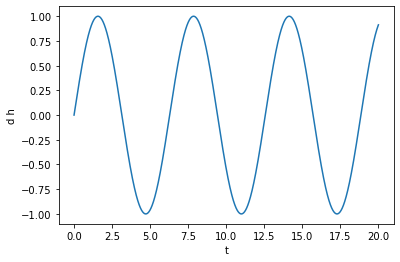

In [4]:
def plot(ser, lab1="d h", lab2="t", *args, **kwargs):
    """Plot Series ser with labels"""
    plt.ylabel(lab1)
    plt.xlabel(lab2)
    plt.plot(ser, *args, **kwargs)
    
plot(gw)

Let's make this more interesting: we square the signal and add Gaussian noise. [TimeSeries](../timeseries_ref.html#kuibit.timeseries.TimeSeries) support directly using all the basic mathematical operations in Python and NumPy, so we can easily square the signal and add another TimeSeries to it.

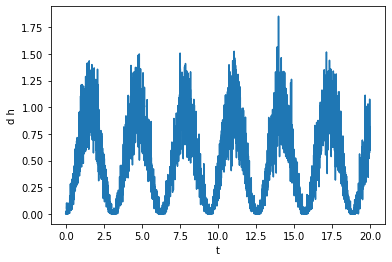

In [5]:
noise = np.random.normal(0, 0.1, len(gw))  # Here we used len() on the TimeSeries
noise_ts = ts.TimeSeries(t, noise)

gw += noise_ts
gw **= 2

plot(gw)

To analyze this signal, first we will smooth it. To do that, we will use the [savgol_smooth_time](../timeseries_ref.html#kuibit.timeseries.TimeSeries.savgol_smooth_time) method, which is a generalized "running average" filter. This method requires length of time over which we want to smooth the data.

In [TimeSeries](../timeseries_ref.html#kuibit.timeseries.TimeSeries) there are always two different methods to do the same task, one with imperative verb (e.g., smooth), and the other with the past tense (e.g., smoothed). The first modifies the data, the second returns a new `TimeSeries` with the operation applied. Here, we will find what smoothing length to use by trial and error, so we will use the second method. 

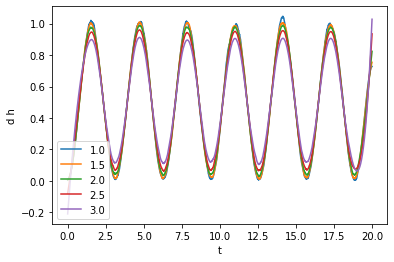

In [6]:
tsmooth = np.linspace(1, 3, 5)

for tsm in tsmooth:
    smoothed = gw.savgol_smoothed_time(tsm)
    plot(smoothed, label=tsm)
plt.legend()

From visual inspection it looks like that ``tsmooth = 1.5`` will work yield a clean series faithful to the original one.

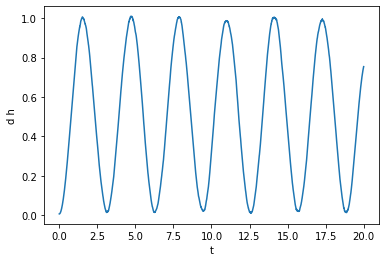

In [7]:
gw.savgol_smooth_time(1.5)
plot(gw)

Next, for fun, we can compute integrals and derivatives. For instance, we can compute what is the integral from 5 to 10.

The integral from 5 to 10 is 2.1915


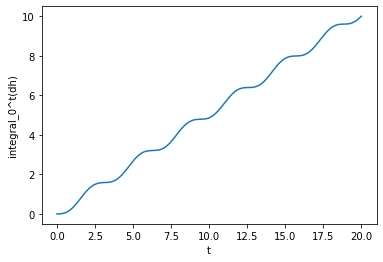

In [8]:
gw_int = gw.integrated()
a = 5
b = 10
print(f"The integral from {a} to {b} is {gw_int(b) - gw_int(a):.4f}")
plot(gw_int, lab1="integral_0^t(dh)")

Here, we showed a very powerful feature of `TimeSeries`: you can call them on a specific time (as we did we ``gw_int(b)``). This is done using splines to interpolate to the points that are not available. Splines can also be used to take derivatives. Alternatively, one can simply take the finite (central) difference. Let's see what's the derivative of ``gw`` using splines and finite difference.

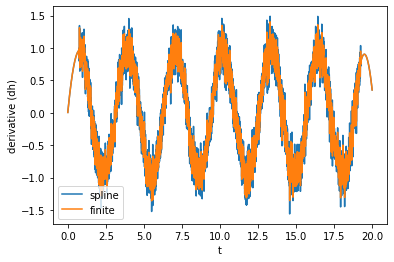

In [9]:
gw_spline_der = gw.spline_differentiated()
gw_numer_der = gw.differentiated()

plot(gw_spline_der, label='spline')
plot(gw_numer_der, lab1="derivative (dh)", label='finite')
plt.legend()

Clearly, derivatives will be noisier than the actual data, so often it is convenient to smooth them out as shown before.

TimeSeries support complex signals. Now, we will create one using `gw` itself. We will copy `gw`, time-shift it, find the common time interval with the original `gw`, and use that as a the imaginary part.

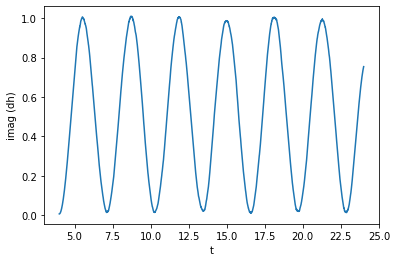

In [10]:
gw_imag = gw.copy()  # It is important to deep copy the object
gw_imag.time_shift(4)

plot(gw_imag, lab1 ="imag (dh)")

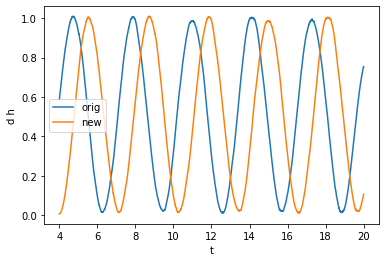

In [11]:
gw, gw_imag = series.sample_common([gw, gw_imag], resample=True)  # Resampling to common times

plot(gw, label="orig")
plot(gw_imag, label="new")
plt.legend()

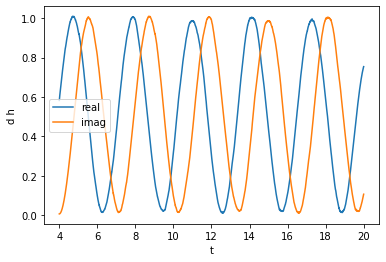

In [12]:
gw_complex = ts.TimeSeries(gw.t, gw.y + 1j * gw_imag.y)

plot(gw_complex.real(), label="real")
plot(gw_complex.imag(), label="imag")
plt.legend()

We can also compute the phase and absolute value. In particular, we will compute the unfolded phase (no wrapping over $2\pi$)

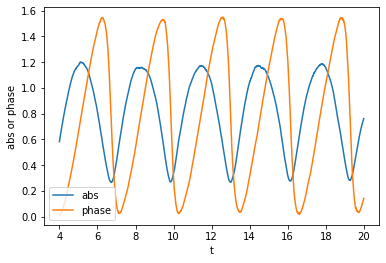

In [13]:
plot(gw_complex.abs(), label='abs')
plot(gw_complex.unfolded_phase(), lab1="abs or phase", label='phase')
plt.legend()

Here, the unfolded phase looks a little bit unusual. This is because we made up the signal.

We can also compute the frequency of the phase, which we can directly smooth.

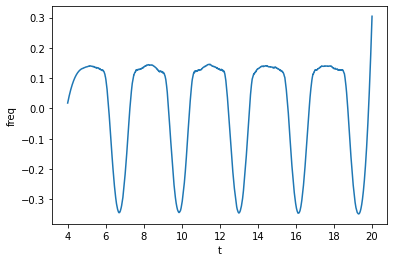

In [14]:
plot(gw_complex.phase_frequency(tsmooth=1.5), lab1="freq")

Next, we will take a Fourier transform. Before, let's pretend that the signal was in geometrized units (as in simulations), and let's make it physical assuming a scale of $M = 1 M_\odot$. For that, use the [unitconv](../unitconv.rst) module. We define a CU object that knows how to convert units.

In [15]:
CU = uc.geom_umass_msun(1) 

# How to convert from geometrized length to physical length?
# Simply multiply times CU.length. Let's check that it is 1.477 km
CU.length  # m

1476.6436994724972

Now we rescale `gw`, assuming that `y` is strain times distance (as usually is). Let's assume a distance of 500 Mpc.

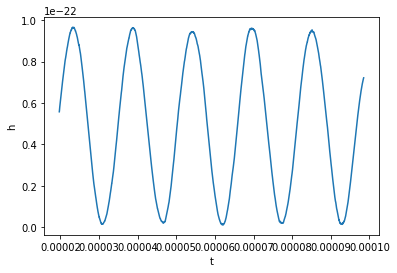

In [16]:
d_Mpc = 500

# inverse = True means from geometrized to physical
gw_physical = gw_complex.time_unit_changed(CU.time, inverse=True)  

gw_physical *= CU.length  # dh -> dh physical
# Now just the strain, since we assume a distance
gw_physical /= (d_Mpc * uc.MEGAPARSEC_SI)

# We have to manually add the redshift
gw_physical.redshifted(luminosity_distance_to_redshift(d_Mpc))

plot(gw_physical.real(), lab1="h")

Okay, now before taking the Fourier transform, we will remove the mean and window our signal. A Tukey window will work.

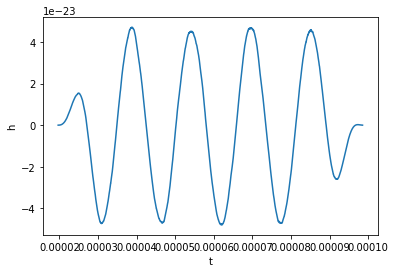

In [17]:
gw_physical.mean_remove()
gw_physical.tukey_window(0.3)
plot(gw_physical.real(), lab1="h")

Finally, we can take the Fourier transform. This is easy to do:

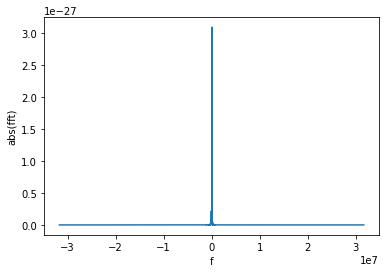

In [18]:
gw_fft = gw_physical.to_FrequencySeries()

# Plotting the amplitude of the Fourier transform
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")

The new object is a `FrequencySeries`. It is very similar to a `TimeSeries` and it shares several properties, methods, and features. 

Let's restrict to only positive frequencies close to zero.

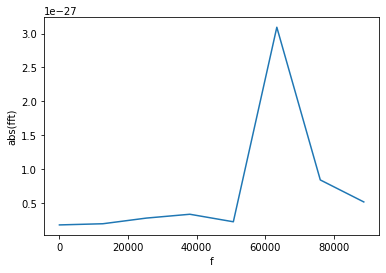

In [19]:
gw_fft.crop(0, 1e5)
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")

We can find the frequency of that peak! For this, we find all the peaks with amplitude larger than 1e-27.

Frequency: 64196.29


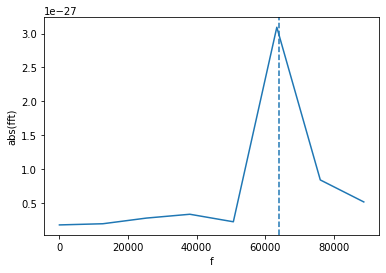

In [20]:
f_peak = gw_fft.peaks_frequencies(1e-27)[0]

print(f"Frequency: {f_peak:.2f}")
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")
plt.axvline(f_peak, ls = 'dashed')

The line is not on the maximum because we use a quadratic interpolation to find a more accurate location of the peak.

Sometimes, it is useful to ignore some data (or example, when we know that the data is invalid). `Series` objects support _masks_ to mark the points we want to ignore. Most functions work transparently with masks: for example, if you ask for the mean of a `Series`, the masked point will be ignored. Other functions do not support masks (most notably, splines). In that case, it is best to completely remove the masked points and work with clean data.

In [21]:
# Let's mask all the point in the spectrum with value larger than 1e-27

spectrum = gw_fft.abs()

print(f"Maximum without mask {spectrum.max():.3e}")

# Apply mask
spectrum.mask_greater(1e-27)

print(f"Maximum with mask {spectrum.max():.3e}")

print(f"Length with mask {len(spectrum)}")

# Remove points
spectrum.mask_remove()

print(f"Length after having removed the masked points {len(spectrum)}")

Maximum without mask 3.094e-27
Maximum with mask 8.379e-28
Length with mask 8
Length after having removed the masked points 7
